In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM

device = torch.device("cuda")
dtype = torch.float

In [2]:
data = np.genfromtxt("../data/data_1d.dat")
data = torch.tensor(data, device = device, dtype = dtype)
data = ((data+1)/2).t()

In [3]:
data.shape

torch.Size([1000, 12000])

In [33]:
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = 200
Nv = data.shape[0]

ep_max = 500

In [34]:
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)   

In [35]:
myRBM.SetVisBias(data)
myRBM.fit(data, ep_max = ep_max)

IT  0
IT  1
IT  2
IT  3
IT  4
IT  5
IT  6
IT  7
IT  8
IT  9
IT  10
IT  11
IT  12
IT  13
IT  14
IT  15
IT  16
IT  17
IT  18
IT  19
IT  20
IT  21
IT  22
IT  23
IT  24
IT  25
IT  26
IT  27
IT  28
IT  29
IT  30
IT  31
IT  32
IT  33
IT  34
IT  35
IT  36
IT  37
IT  38
IT  39
IT  40
IT  41
IT  42
IT  43
IT  44
IT  45
IT  46
IT  47
IT  48
IT  49
IT  50
IT  51
IT  52
IT  53
IT  54
IT  55
IT  56
IT  57
IT  58
IT  59
IT  60
IT  61
IT  62
IT  63
IT  64
IT  65
IT  66
IT  67
IT  68
IT  69
IT  70
IT  71
IT  72
IT  73
IT  74
IT  75
IT  76
IT  77
IT  78
IT  79
IT  80
IT  81
IT  82
IT  83
IT  84
IT  85
IT  86
IT  87
IT  88
IT  89
IT  90
IT  91
IT  92
IT  93
IT  94
IT  95
IT  96
IT  97
IT  98
IT  99
IT  100
IT  101
IT  102
IT  103
IT  104
IT  105
IT  106
IT  107
IT  108
IT  109
IT  110
IT  111
IT  112
IT  113
IT  114
IT  115
IT  116
IT  117
IT  118
IT  119
IT  120
IT  121
IT  122
IT  123
IT  124
IT  125
IT  126
IT  127
IT  128
IT  129
IT  130
IT  131
IT  132
IT  133
IT  134
IT  135
IT  136
IT  137
IT  13

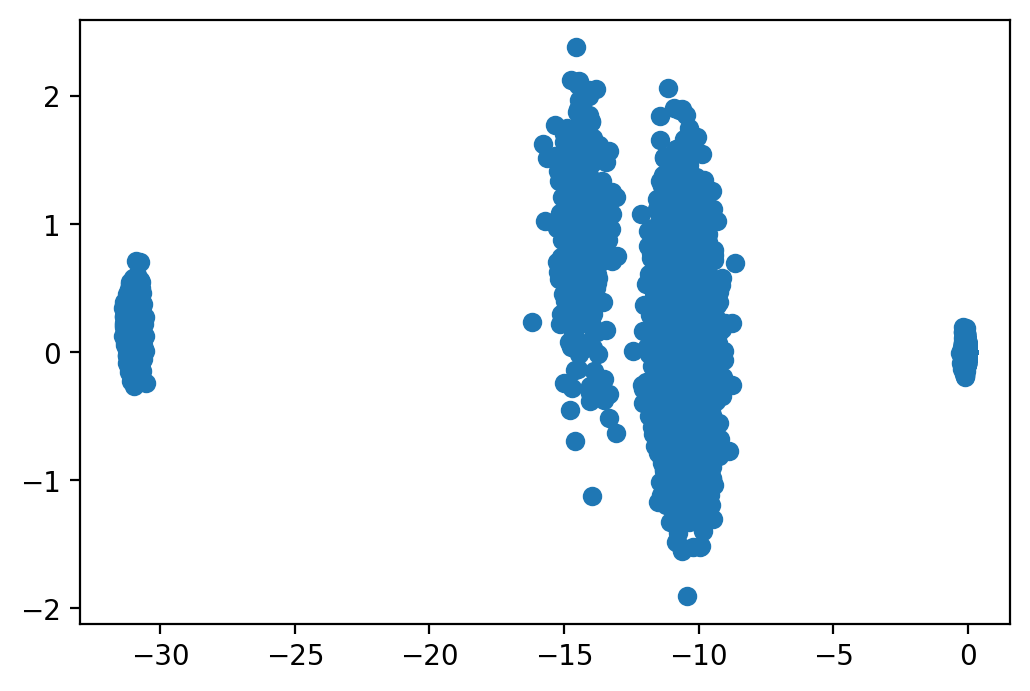

In [42]:
plt.figure(dpi=200)
_, _, V = torch.svd(myRBM.W)
proj = np.array(torch.mm(data.T, V).cpu())
plt.scatter(proj[:,0], proj[:,1])

In [43]:
data.T.shape
V.shape

torch.Size([1000, 200])

In [45]:
torch.matmul(data.T, V).shape

torch.Size([12000, 200])